# Unsupervised Learning 2 

## Lesson 2: RFM and Clustering

### Part 1: Calculate RFM Values

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
df = pd.read_csv("OnlineRetail_Filtered.csv")

In [3]:
df.dtypes

InvoiceNo        int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [4]:
df.shape

(339702, 8)

In [5]:
# Set the data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = pd.Categorical(df['CustomerID'].astype(int))
df['StockCode'] = pd.Categorical(df['StockCode'])
df = df.drop(['Country'], axis=1)

In [6]:
df.dtypes

InvoiceNo               int64
StockCode            category
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID           category
dtype: object

In [7]:
# Extract only the date from the InvoiceDate column
df['InvoiceDay'] = df.InvoiceDate.apply(lambda x: dt.datetime(x.year, x.month, x.day))

In [8]:
# create reference date
ref_date = max(df.InvoiceDay) + dt.timedelta(1)
print(ref_date)

2011-12-10 00:00:00


In [9]:
# Calculate Total spending
df['TotalSum'] = df.Quantity * df.UnitPrice

In [10]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceDay,TotalSum
0,538365,22469,HEART OF WICKER SMALL,8,2010-12-12 10:11:00,1.65,17243,2010-12-12,13.20
1,538365,84030E,ENGLISH ROSE HOT WATER BOTTLE,1,2010-12-12 10:11:00,4.25,17243,2010-12-12,4.25
2,538365,22112,CHOCOLATE HOT WATER BOTTLE,3,2010-12-12 10:11:00,4.95,17243,2010-12-12,14.85
3,538365,22835,HOT WATER BOTTLE I AM SO POORLY,5,2010-12-12 10:11:00,4.65,17243,2010-12-12,23.25
4,538365,84029E,RED WOOLLY HOTTIE WHITE HEART.,4,2010-12-12 10:11:00,3.75,17243,2010-12-12,15.00


In [11]:
# Display number of unique customers
df.CustomerID.nunique()

3849

In [12]:
# Calculate the RFM columns
rfm = df.groupby('CustomerID').agg({
    'InvoiceNo':'count',
    'TotalSum':'sum',
    'InvoiceDay': lambda x: ref_date - x.max()})

In [13]:
# Validate that we have the correct dataset shape: 1 row per customer
rfm.shape

(3849, 3)

In [14]:
# Datatypes for the RFM dataframe follows from the types of the source data
rfm.dtypes

InvoiceNo               int64
TotalSum              float64
InvoiceDay    timedelta64[ns]
dtype: object

In [15]:
rfm.describe()

,InvoiceNo,TotalSum,InvoiceDay
count,3849.000000,3849.000000,3849
mean,88.257210,1818.910313,87 days 14:53:46.812159
std,212.142127,7183.480529,92 days 22:58:05.450099
min,1.000000,3.750000,1 days 00:00:00
25%,16.000000,293.100000,18 days 00:00:00
50%,40.000000,642.800000,50 days 00:00:00
75%,97.000000,1550.140000,134 days 00:00:00
max,7661.000000,231822.690000,363 days 00:00:00


In [16]:
# Rename the columns to RFM
rfm.rename(columns={
    'InvoiceNo':'Frequency',
    'TotalSum':'Monetary',
    'InvoiceDay':'Recency'
}, inplace=True)

rfm['Recency'] = rfm['Recency'].dt.days # Convert to numerical to simplify calculations

In [17]:
rfm.head()

,Frequency,Monetary,Recency
CustomerID,,,
12346,1,77183.60,326
12747,96,3837.45,3
12748,4051,30301.40,1
12749,199,4090.88,4
12820,59,942.34,4


### Part 2: Clustering

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

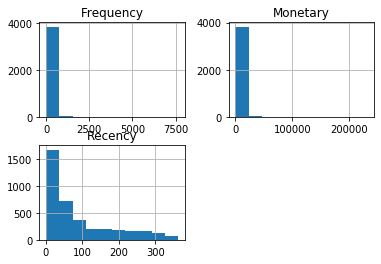

In [19]:
# Let's look at the distribution of the 3 columns
rfm.hist()
plt.savefig("rfm_hist.png")
plt.show()

In [20]:
# Apply a log transform to the data
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1)

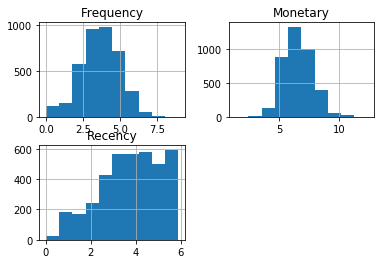

In [21]:
# Look at the histogram for the transformed data. Did it work?
rfm_log.hist()
plt.savefig("rfm_log_hist.png")
plt.show()

In [22]:
rfm_log.describe()

# Compare the range of values for the columns after the transform. Do we need to normalize for the modelling?

,Recency,Frequency,Monetary
count,3849.000000,3849.000000,3849.000000
mean,3.759722,3.647189,6.528944
std,1.364555,1.328443,1.240683
min,0.000000,0.000000,1.321756
25%,2.890372,2.772589,5.680514
50%,3.912023,3.688879,6.465834
75%,4.897840,4.574711,7.346101
max,5.894403,8.943898,12.353728


In [23]:
# Calculate the inertia values for various values of k
from sklearn.cluster import KMeans
inertia = {}
for k in range(1,11):
    mod = KMeans(n_clusters=k, random_state=42)
    mod.fit(rfm_log)
    inertia[k] = mod.inertia_

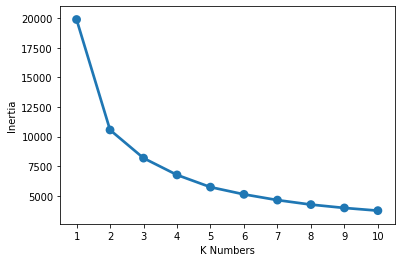

In [24]:
# Create an elbow plot to determine the best k
import seaborn as sns
sns.pointplot(x = list(inertia.keys()), y = list(inertia.values()))
plt.xlabel('K Numbers')
plt.ylabel('Inertia')
plt.savefig("rfm_log_elbow.png")
plt.show()

# Based on the plot, which is the best value?

In [25]:
# Selecting k=3 as the best choice, train the model and label the data
model = KMeans(n_clusters=3)
model.fit(rfm_log)
rfm_log['cluster'] = model.predict(rfm_log)
rfm_log.head()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12346,5.786897,0.000000,11.253942,2
12747,1.098612,4.564348,8.252563,0
12748,0.000000,8.306719,10.318949,0
12749,1.386294,5.293305,8.316515,0
12820,1.386294,4.077537,6.848366,0


In [26]:
# Import library to enable 3D plots
from mpl_toolkits import mplot3d

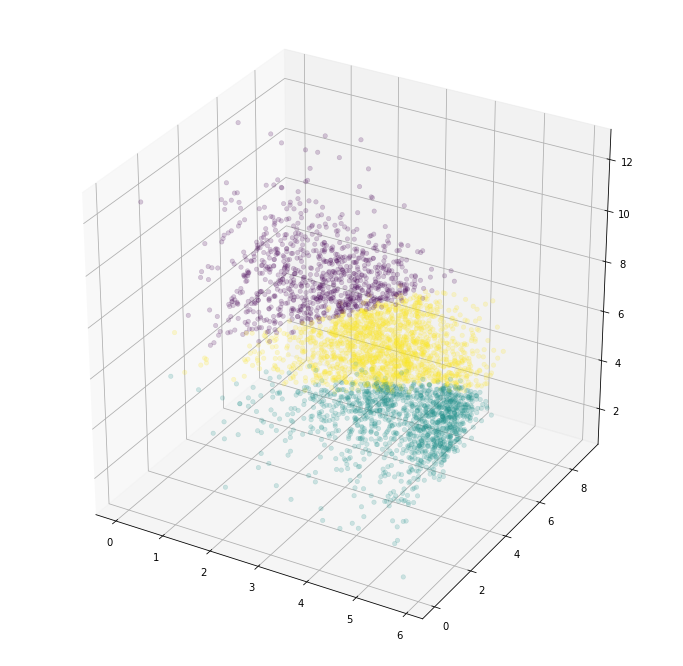

In [27]:
# Plot RFM as a 3D scatter plot
# fig = plt.figure()
fig=plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.scatter(rfm_log.Recency, rfm_log.Frequency, rfm_log.Monetary, c=rfm_log.cluster, cmap='viridis', linewidth=0.5, alpha=0.2);
# ax.set_xlabel('Recency')
# ax.set_ylabel('Frequency')
# ax.set_zlabel('Monetary')
plt.savefig("rfm_3dscatter.png")
plt.show()
# How do the clusters look? Are the different clusters easily separable?

In [28]:
# Let's try displaying the data as a 2d plot instead. Here we use PCA to project the data onto a 2d space.
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(rfm_log)
rfm_pca2 = pca.transform(rfm_log)

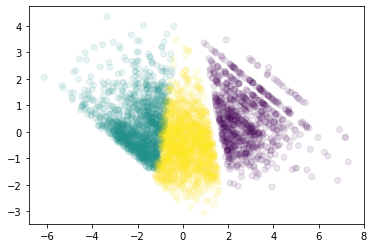

In [29]:
# Plot the data as a scatterplot
(x, y) = (rfm_pca2[:,0], rfm_pca2[:,1])
plt.scatter(x,y, c=rfm_log.cluster, alpha=0.1, cmap='viridis')
plt.show()

In [30]:
model.cluster_centers_

array([[2.06389968, 5.08033965, 7.94518302],
       [4.79354384, 2.33139563, 5.39229166],
       [3.82770275, 3.94594487, 6.69234821]])

In [31]:
# Let's compare the centroid values
centroids_log = pd.DataFrame(model.cluster_centers_, columns=['Recency', 'Frequency', 'Monetary'])
print(centroids_log)

    Recency  Frequency  Monetary
0  2.063900   5.080340  7.945183
1  4.793544   2.331396  5.392292
2  3.827703   3.945945  6.692348


In [32]:
# Convert these centroid values back to the original scale
centroids_orig = centroids_log[['Recency', 'Frequency', 'Monetary']].apply(np.exp, axis = 1).round(3)
print(centroids_orig)

   Recency  Frequency  Monetary
0    7.877    160.829  2821.949
1  120.728     10.292   219.706
2   45.957     51.725   806.213


In [33]:
pd.DataFrame(model.cluster_centers_, columns=['Recency', 'Frequency', 'Monetary']).apply(np.exp, axis = 1).round(3)

,Recency,Frequency,Monetary
0,7.877,160.829,2821.949
1,120.728,10.292,219.706
2,45.957,51.725,806.213


### Part 3: Splitting the data by cluster for further analyses

In [34]:
# Extract only the small customers (high recency, low frequency, low monetary)
# Use the correct cluster id from the dataframe above as the cluster id will change from run to run
small_customers = rfm_log[rfm_log.cluster == 1] 
print(small_customers.shape)

(1327, 4)


In [35]:
# convert the values back to normal scale and display
small_customers = small_customers[['Recency', 'Frequency', 'Monetary']].apply(np.exp, axis = 1)
small_customers['Recency'] = np.rint(small_customers['Recency']).astype(int)
small_customers['Frequency'] = np.rint(small_customers['Frequency']).astype(int)
small_customers['Monetary'] = np.round(small_customers['Monetary'], 2)
print(small_customers.head())

            Recency  Frequency  Monetary
CustomerID                              
12821           215          6     92.72
12823            75          5   1759.50
12829           337         11    293.00
12831           263          9    215.05
12833           146         24    417.38


In [36]:
# Save the RFM for small customers
small_customers.to_csv('small_cust.csv')

In [37]:
# Similarly, extract the large customers, display and save
large_customers = rfm_log[rfm_log.cluster == 0] # Remember to check this id based in the labeled centroid dataframe above
print(large_customers.shape)

(875, 4)


In [38]:
large_customers = large_customers[['Recency', 'Frequency', 'Monetary']].apply(np.exp, axis = 1)
large_customers['Recency'] = np.rint(large_customers['Recency']).astype(int)
large_customers['Frequency'] = np.rint(large_customers['Frequency']).astype(int)
large_customers['Monetary'] = np.round(large_customers['Monetary'], 2)
print(large_customers.head())

            Recency  Frequency  Monetary
CustomerID                              
12747             3         96   3837.45
12748             1       4051  30301.40
12749             4        199   4090.88
12820             4         59    942.34
12826             3         82   1319.72


In [39]:
large_customers.to_csv('large_cust.csv')